# Build and evaluate CatBoost model

In [2]:
!pip install -q catboost

     |████████████████████████████████| 69.2MB 43kB/s 


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Coursework

/content/drive/MyDrive/Coursework


In [36]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from catboost import Pool, CatBoostClassifier

%matplotlib inline

## Fit to categories

In [78]:
df = pd.read_csv("collection_final.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [79]:
le = LabelEncoder()
y_train = le.fit_transform(df["category"])
y_train = list(y_train)
df = df.drop(["title", "category", "jingle_fname", "kmeans_clusters", "embeddings_clusters"], axis=1)

In [80]:
genre_le = LabelEncoder()
df["genre"] = genre_le.fit_transform(df["genre"])

key_le = LabelEncoder()
df["key"] = key_le.fit_transform(df["key"])

In [81]:
evalres = []
fi = []

slices = [0, 10, 20, 30, 40, 50, 60, 70, 80, 91]

for si in tqdm(tuple(zip(slices[:-1], slices[1:]))):
  train_pool = Pool(data=pd.concat([df.head(si[0]), df.tail(91 - si[1])]), label=y_train[0:si[0]]+y_train[si[1]:])
  test_pool = Pool(data=df[si[0]:si[1]], label=y_train[si[0]:si[1]])

  model = CatBoostClassifier(
      iterations=100,
      learning_rate=0.1,
      random_strength=0.1,
      depth=8,
      loss_function='MultiClass',
      eval_metric='Accuracy',
      leaf_estimation_method='Newton',
      task_type="GPU",
      devices='0:1'
  )

  model.fit(train_pool, eval_set=test_pool, silent=True)
  evalres.append(model.best_score_['validation'])
  fi.append(model.get_feature_importance())

In [82]:
print("Mean model accuracy:", np.mean([e["Accuracy"] for e in evalres]))

Mean model accuracy: 0.38282828282828285


In [83]:
fi_df = pd.DataFrame(fi)
fi_df.columns = df.columns
fi_df

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,genre,key
0,1.598339,0.000000,3.926876,0.596798,0.320428,0.902051,1.549550,3.218422,1.814661,0.408015,0.000000,0.330438,0.000000,0.038350,2.102297,3.027803,0.000000,3.481843,1.994726,2.187729,1.904411,2.915981,2.021932,0.103894,0.410129,3.612893,0.355805,0.126018,0.749739,1.020121,1.387213,0.336207,1.774837,2.299384,2.920675,1.469287,4.061432,1.038014,3.613026,2.595293,1.610721,0.753454,5.822315,2.432273,0.957361,0.217940,1.879547,2.344110,3.854271,0.996078,0.000000,1.565535,0.874939,0.000000,2.442346,1.654628,0.459900,9.513429,0.000000,0.406535
1,1.839815,1.149479,0.857101,1.365234,1.053859,0.573556,4.774464,2.483704,0.000000,0.856860,1.260868,0.372803,0.266392,2.572582,1.514456,0.936679,0.100495,3.091430,1.176433,0.629323,0.329098,1.851717,0.806525,2.358436,0.951994,4.935428,1.649698,3.910280,0.874661,1.445795,0.634679,0.293543,0.000000,0.737762,1.123815,0.635892,0.294951,1.356377,1.861040,9.942879,0.000000,2.058491,2.867127,3.231814,0.462533,0.851135,4.083706,4.314973,0.822237,1.366584,0.000000,0.443505,2.231241,1.424178,1.125272,4.619057,2.761174,1.728767,1.710679,1.027425
2,0.000000,0.000000,2.012333,0.000000,0.000000,0.000000,0.000000,5.002511,0.000000,1.780219,5.222287,0.000000,0.000000,7.098496,0.000000,0.000000,0.000000,7.777543,2.373482,0.000000,0.000000,0.000000,0.000000,3.934826,0.000000,2.977512,0.000000,0.000000,0.000000,0.000000,9.350090,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.863667,6.484513,2.824490,2.984194,0.000000,2.044674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.083530,4.294466,7.920475,0.000000,0.000000,6.280471,0.000000,0.000000,5.690219,0.000000,0.000000
3,0.000000,0.000000,1.433747,0.845073,1.052867,0.000000,2.142257,0.000000,0.599581,0.000000,0.000000,0.585665,0.000000,1.935105,1.928984,0.402614,0.000000,5.713474,0.437398,1.306308,1.258997,0.000000,1.803601,0.000000,1.271644,0.762730,1.994600,5.428749,2.024549,3.911830,1.086542,0.985484,3.235314,3.672550,0.000000,0.000000,0.000000,0.000000,2.880494,9.304562,0.813453,2.168826,4.696872,2.759653,0.000000,1.393248,1.044273,2.104505,1.613672,4.587605,0.000000,0.000000,0.000000,0.000000,4.044305,2.102793,3.172673,2.876739,1.435293,7.181370
4,0.000000,0.000000,0.000000,0.000000,3.444282,0.000000,0.000000,0.000000,18.825931,3.864923,0.000000,7.740176,0.000000,9.853895,0.000000,0.000000,0.000000,0.000000,9.237854,0.000000,0.000000,0.000000,7.427752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.545662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.183975,4.044985,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.982206,5.108074,0.000000,0.000000,0.000000,0.000000,0.000000,3.000796,0.000000,0.000000,12.739488,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,3.339247,0.000000,0.000000,0.000000,1.260783,0.000000,0.000000,0.000000,18.638963,15.775096,0.000000,0.000000,4.599991,0.000000,0.000000,0.000000,0.000000,2.966472,0.000000,2.064254,4.609182,0.000000,0.000000,0.000000,0.000000,2.360367,0.000000,0.000000,0.000000,4.093803,1.462006,0.000000,2.898858,2.194529,2.886644,0.000000,0.000000,6.170519,0.000000,0.000000,0.000000,0.000000,3.767438,0.000000,5.208519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.586543,8.116785,0.000000,0.000000
6,4.687764,8

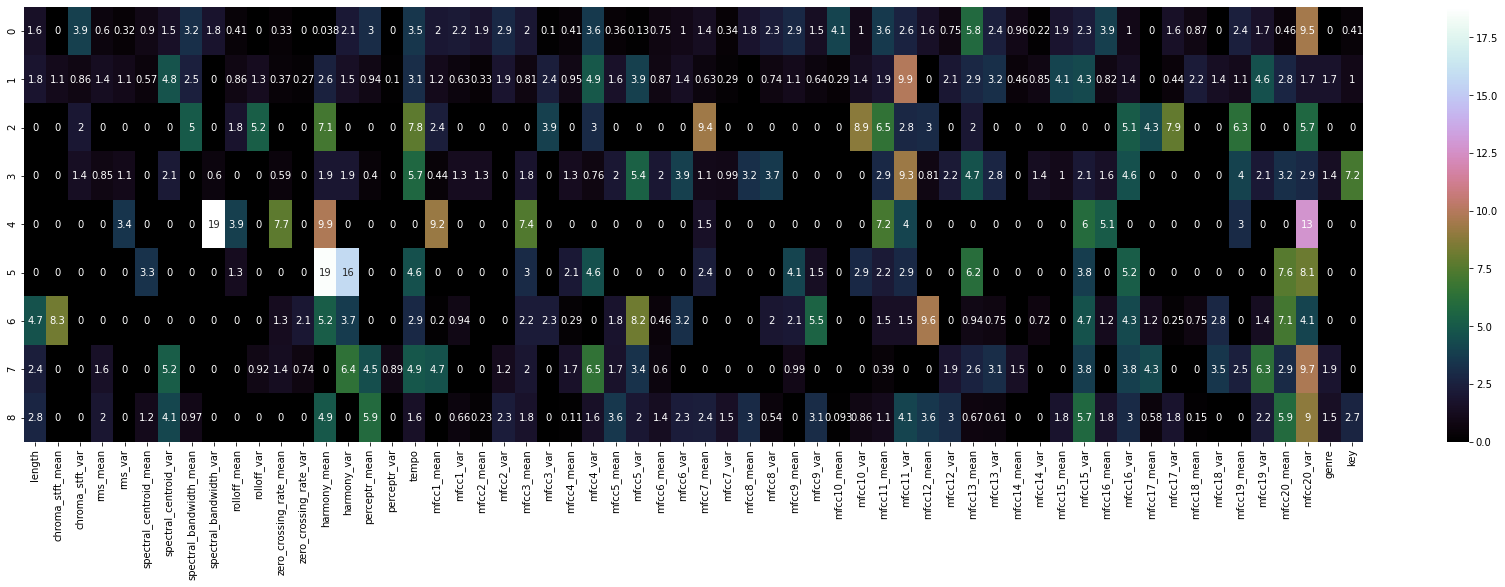

In [84]:
plt.figure(figsize=(30, 8))
sns.heatmap(fi_df, vmax=max([max(f) for f in fi]), square=False, annot=True, cmap='cubehelix')

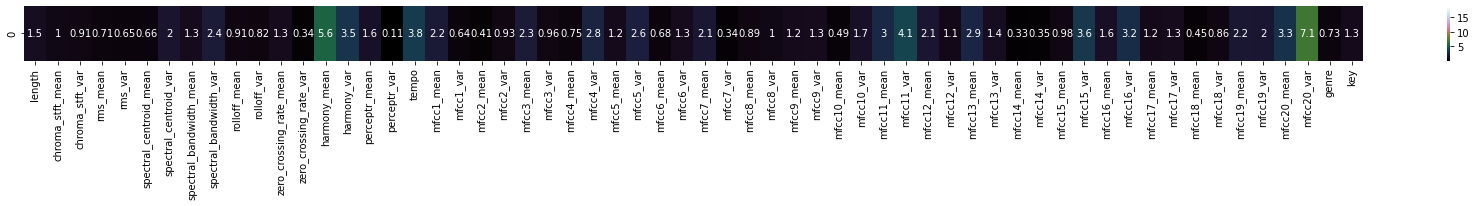

In [85]:
mfi_df = pd.DataFrame([np.mean(fi, axis=0)])
mfi_df.columns = df.columns
plt.figure(figsize=(30, 1))
sns.heatmap(mfi_df, vmax=max([max(f) for f in fi]), square=False, annot=True, cmap='cubehelix')

## Fit to embedding clusters

In [69]:
df = pd.read_csv("collection_final.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [70]:
y_train = list(df["embeddings_clusters"])
df = df.drop(["title", "category", "jingle_fname", "kmeans_clusters", "embeddings_clusters"], axis=1)

In [71]:
genre_le = LabelEncoder()
df["genre"] = genre_le.fit_transform(df["genre"])

key_le = LabelEncoder()
df["key"] = key_le.fit_transform(df["key"])

In [72]:
evalres = []
fi = []

slices = [0, 10, 20, 30, 40, 50, 60, 70, 80, 91]

for si in tqdm(tuple(zip(slices[:-1], slices[1:]))):
  train_pool = Pool(data=pd.concat([df.head(si[0]), df.tail(91 - si[1])]), label=y_train[0:si[0]]+y_train[si[1]:])
  test_pool = Pool(data=df[si[0]:si[1]], label=y_train[si[0]:si[1]])

  model = CatBoostClassifier(
      iterations=100,
      learning_rate=0.1,
      random_strength=0.1,
      depth=8,
      loss_function='MultiClass',
      eval_metric='Accuracy',
      leaf_estimation_method='Newton',
      task_type="GPU",
      devices='0:1'
  )

  model.fit(train_pool, eval_set=test_pool, silent=True)
  evalres.append(model.best_score_['validation'])
  fi.append(model.get_feature_importance())

In [77]:
print("Mean model accuracy:", np.mean([e["Accuracy"] for e in evalres]))

Mean model accuracy: 0.26262626262626265


In [74]:
fi_df = pd.DataFrame(fi)
fi_df.columns = df.columns
fi_df

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,genre,key
0,1.357370,0.000000,0.000000,0.227738,4.149433,2.458573,0.000000,0.000000,0.000000,0.615670,2.950546,0.000000,0.854022,9.256504,0.000000,1.126485,8.917877,2.428992,0.919562,1.461789,0.793379,0.000000,0.000000,1.220030,0.000000,0.000000,0.448395,0.000000,0.713067,3.576319,4.940699,0.000000,2.401299,0.000000,0.000000,0.000000,0.000000,3.333446,8.987003,7.974381,2.468026,0.000000,3.140391,0.000000,0.000000,0.000000,0.000000,2.378570,1.849862,4.489603,2.613057,0.936610,1.837996,0.000000,4.065681,2.585810,2.003091,0.000000,0.518725,0.000000
1,2.221539,0.999490,2.235133,1.052543,2.005175,0.629466,0.405415,2.282503,1.109664,2.527940,1.337018,0.799972,0.669827,2.517911,2.917371,1.868512,2.638077,1.695293,0.900836,0.829589,0.210736,0.098087,2.438238,1.344479,0.330054,0.590282,2.336550,1.622308,5.807133,2.673118,2.392898,1.457178,0.705744,1.398908,1.079542,1.081290,0.470997,0.991273,4.521089,2.274537,2.845683,0.205374,1.404533,2.863761,0.937551,1.176771,0.891222,1.576252,0.000000,1.135139,1.083635,1.129457,3.155179,2.489112,2.494806,4.253286,3.100507,1.840231,1.382987,0.566797
2,0.448640,3.422149,0.704132,2.694576,1.073476,0.556926,0.649745,1.075028,0.123706,0.968752,0.286167,0.626155,3.946247,1.017506,1.831750,1.350201,2.326804,0.955244,0.183944,1.922988,0.192702,2.374448,0.753379,1.135562,2.973204,0.724103,2.542233,1.149698,1.023321,0.333793,2.037178,3.029735,0.426450,0.616711,1.575173,1.131053,3.399439,1.375335,3.133037,1.130575,0.813369,0.851633,2.725369,4.660274,0.062509,1.248622,1.249151,1.668417,0.416123,7.071827,2.871970,0.517536,1.905962,2.900963,5.706232,0.333008,3.663159,2.055611,0.724505,1.332496
3,1.642095,1.072151,5.196942,0.770400,4.401985,0.000000,1.598142,1.356563,2.863621,0.404833,0.902085,0.000000,4.773259,0.450319,0.000000,2.734956,0.375758,0.000000,0.000000,1.694323,0.000000,2.310833,3.631211,0.000000,1.985159,0.689849,0.000000,1.041563,1.686794,2.481652,0.000000,1.385453,0.000000,3.664478,0.000000,0.000000,0.000000,0.000000,1.053829,3.258457,0.673877,0.000000,1.160926,0.000000,2.550456,0.000000,2.147379,0.994848,0.000000,4.402169,1.563403,0.000000,2.985678,3.928709,5.764372,7.080979,3.124595,6.192550,0.000000,4.003347
4,1.156892,0.000000,0.314052,0.000000,5.513195,5.102769,0.000000,1.371453,1.566583,0.000000,0.000000,0.000000,0.000000,0.000000,10.425373,0.000000,2.011036,3.129762,7.163306,0.000000,0.000000,0.000000,0.000000,3.345874,0.000000,0.000000,0.000000,9.741585,3.853856,4.624687,0.000000,0.000000,0.000000,0.000000,0.000000,4.925596,4.296772,3.309760,1.730254,1.463434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.470317,1.779494,0.000000,0.000000,3.053859,3.491736,11.741804,0.000000,0.000000,0.736562,0.000000,3.679988,0.000000,0.000000
5,0.000000,3.278874,2.443868,2.276427,0.000000,2.083220,2.142540,0.000000,0.000000,0.000000,0.000000,5.707602,0.000000,4.976611,2.578542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.550966,0.000000,0.000000,0.000000,7.326376,6.100565,13.910150,0.000000,0.000000,4.978213,0.000000,0.000000,0.000000,4.791936,0.000000,0.000000,2.063781,0.000000,4.507414,0.000000,6.839879,0.000000,0.000000,0.000000,0.000000,8.447242,0.000000,0.000000,0.000000,2.772169,3.388163,1.958985,0.000000,0.000000,0.000000,4.876477
6,9.147029,0.

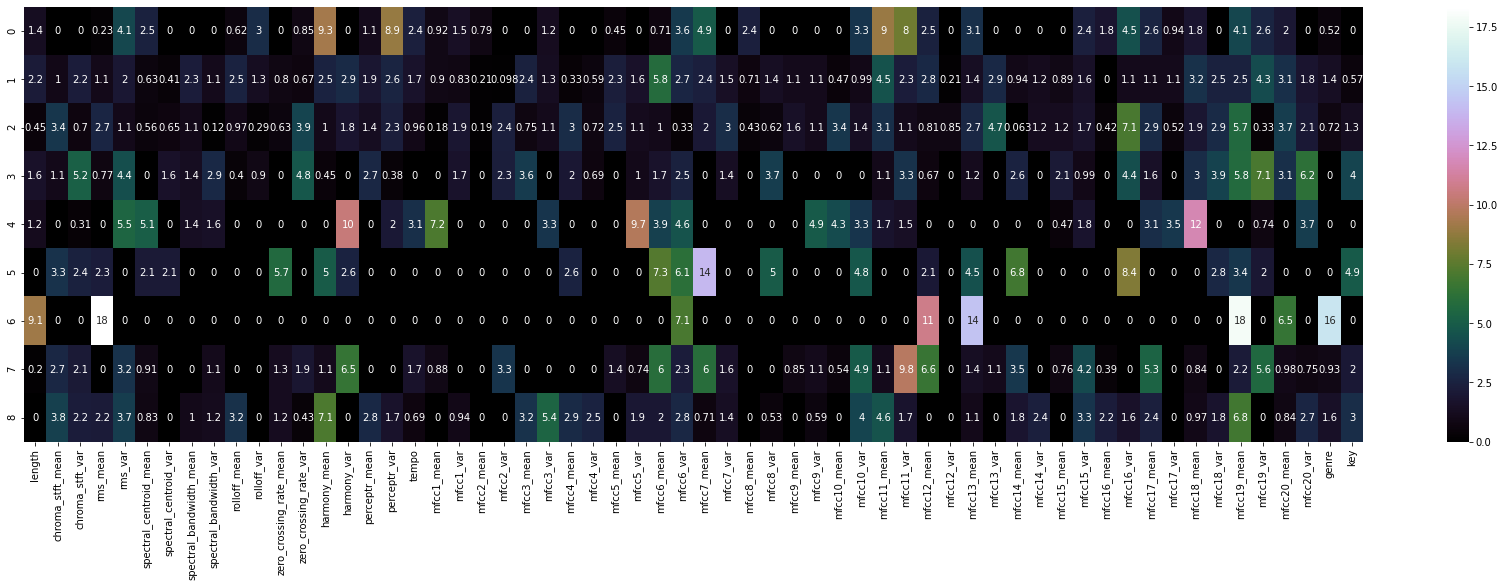

In [75]:
plt.figure(figsize=(30, 8))
sns.heatmap(fi_df, vmax=max([max(f) for f in fi]), square=False, annot=True, cmap='cubehelix')

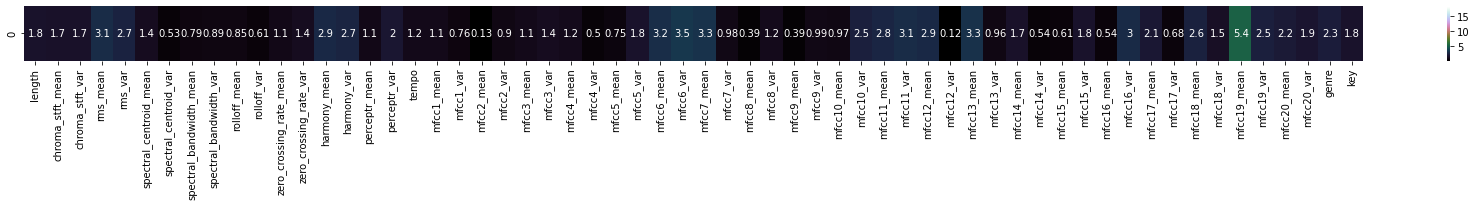

In [76]:
mfi_df = pd.DataFrame([np.mean(fi, axis=0)])
mfi_df.columns = df.columns
plt.figure(figsize=(30, 1))
sns.heatmap(mfi_df, vmax=max([max(f) for f in fi]), square=False, annot=True, cmap='cubehelix')